The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Multivariable Calculus
:label:`sec_multivariable_calculus`

Now that we have a fairly strong understanding of derivatives of a function of a single variable, let's return to our original question where we were considering a loss function of potentially billions of weights.

## Higher-Dimensional Differentiation
What :numref:`sec_single_variable_calculus` tells us is that if we change a single one of these billions of weights leaving every other one fixed, we know what will happen!  This is nothing more than a function of a single variable, so we can write

$$L(w_1+\epsilon_1, w_2, \ldots, w_N) \approx L(w_1, w_2, \ldots, w_N) + \epsilon_1 \frac{d}{dw_1} L(w_1, w_2, \ldots, w_N).$$
:eqlabel:`eq_part_der`

We will call the derivative in one variable while fixing the other variables the *partial derivative*, and we will use the notation $\frac{\partial}{\partial w_1}$ for the derivative in :eqref:`eq_part_der`.

Now, let's take this and change $w_2$ a little bit to $w_2 + \epsilon_2$:

$$
\begin{aligned}
L(w_1+\epsilon_1, w_2+\epsilon_2, \ldots, w_N) & \approx L(w_1, w_2+\epsilon_2, \ldots, w_N) + \epsilon_1 \frac{\partial}{\partial w_1} L(w_1, w_2+\epsilon_2, \ldots, w_N+\epsilon_N) \\
& \approx L(w_1, w_2, \ldots, w_N) \\
& \quad + \epsilon_2\frac{\partial}{\partial w_2} L(w_1, w_2, \ldots, w_N) \\
& \quad + \epsilon_1 \frac{\partial}{\partial w_1} L(w_1, w_2, \ldots, w_N) \\
& \quad + \epsilon_1\epsilon_2\frac{\partial}{\partial w_2}\frac{\partial}{\partial w_1} L(w_1, w_2, \ldots, w_N) \\
& \approx L(w_1, w_2, \ldots, w_N) \\
& \quad + \epsilon_2\frac{\partial}{\partial w_2} L(w_1, w_2, \ldots, w_N) \\
& \quad + \epsilon_1 \frac{\partial}{\partial w_1} L(w_1, w_2, \ldots, w_N).
\end{aligned}
$$

We have again used the idea that $\epsilon_1\epsilon_2$ is a higher order term that we can discard in the same way we could discard $\epsilon^{2}$ in the previous section, along with what we saw in :eqref:`eq_part_der`.  By continuing in this manner, we may write that

$$
L(w_1+\epsilon_1, w_2+\epsilon_2, \ldots, w_N+\epsilon_N) \approx L(w_1, w_2, \ldots, w_N) + \sum_i \epsilon_i \frac{\partial}{\partial w_i} L(w_1, w_2, \ldots, w_N).
$$

This may look like a mess, but we can make this more familiar by noting that the sum on the right looks exactly like a dot product, so if we let

$$
\boldsymbol{\epsilon} = [\epsilon_1, \ldots, \epsilon_N]^\top \; \textrm{and} \;
\nabla_{\mathbf{x}} L = \left[\frac{\partial L}{\partial x_1}, \ldots, \frac{\partial L}{\partial x_N}\right]^\top,
$$

then

$$L(\mathbf{w} + \boldsymbol{\epsilon}) \approx L(\mathbf{w}) + \boldsymbol{\epsilon}\cdot \nabla_{\mathbf{w}} L(\mathbf{w}).$$
:eqlabel:`eq_nabla_use`

We will call the vector $\nabla_{\mathbf{w}} L$ the *gradient* of $L$.

Equation :eqref:`eq_nabla_use` is worth pondering for a moment.  It has exactly the format that we encountered in one dimension, just we have converted everything to vectors and dot products.  It allows us to tell approximately how the function $L$ will change given any perturbation to the input.  As we will see in the next section, this will provide us with an important tool in understanding geometrically how we can learn using information contained in the gradient.

But first, let's see this approximation at work with an example.  Suppose that we are working with the function

$$
f(x, y) = \log(e^x + e^y) \textrm{ with gradient } \nabla f (x, y) = \left[\frac{e^x}{e^x+e^y}, \frac{e^y}{e^x+e^y}\right].
$$

If we look at a point like $(0, \log(2))$, we see that

$$
f(x, y) = \log(3) \textrm{ with gradient } \nabla f (x, y) = \left[\frac{1}{3}, \frac{2}{3}\right].
$$

Thus, if we want to approximate $f$ at $(\epsilon_1, \log(2) + \epsilon_2)$,  we see that we should have the specific instance of :eqref:`eq_nabla_use`:

$$
f(\epsilon_1, \log(2) + \epsilon_2) \approx \log(3) + \frac{1}{3}\epsilon_1 + \frac{2}{3}\epsilon_2.
$$

We can test this in code to see how good the approximation is.


In [1]:
%matplotlib inline
import numpy as np
import torch
from IPython import display
from mpl_toolkits import mplot3d
from d2l import torch as d2l


def f(x, y):
    return torch.log(torch.exp(x) + torch.exp(y))
def grad_f(x, y):
    return torch.tensor([torch.exp(x) / (torch.exp(x) + torch.exp(y)),
                     torch.exp(y) / (torch.exp(x) + torch.exp(y))])

epsilon = torch.tensor([0.01, -0.03])
grad_approx = f(torch.tensor([0.]), torch.log(
    torch.tensor([2.]))) + epsilon.dot(
    grad_f(torch.tensor([0.]), torch.log(torch.tensor(2.))))
true_value = f(torch.tensor([0.]) + epsilon[0], torch.log(
    torch.tensor([2.])) + epsilon[1])
f'approximation: {grad_approx}, true Value: {true_value}'

'approximation: tensor([1.0819]), true Value: tensor([1.0821])'

## Geometry of Gradients and Gradient Descent
Consider the expression from :eqref:`eq_nabla_use` again:

$$
L(\mathbf{w} + \boldsymbol{\epsilon}) \approx L(\mathbf{w}) + \boldsymbol{\epsilon}\cdot \nabla_{\mathbf{w}} L(\mathbf{w}).
$$

Let's suppose that I want to use this to help minimize our loss $L$.  Let's understand geometrically the algorithm of gradient descent first described in  :numref:`sec_autograd`. What we will do is the following:

1. Start with a random choice for the initial parameters $\mathbf{w}$.
2. Find the direction $\mathbf{v}$ that makes $L$ decrease the most rapidly at $\mathbf{w}$.
3. Take a small step in that direction: $\mathbf{w} \rightarrow \mathbf{w} + \epsilon\mathbf{v}$.
4. Repeat.

The only thing we do not know exactly how to do is to compute the vector $\mathbf{v}$ in the second step.  We will call such a direction the *direction of steepest descent*.  Using the geometric understanding of dot products from :numref:`sec_geometry-linear-algebraic-ops`, we see that we can rewrite :eqref:`eq_nabla_use` as

$$
L(\mathbf{w} + \mathbf{v}) \approx L(\mathbf{w}) + \mathbf{v}\cdot \nabla_{\mathbf{w}} L(\mathbf{w}) = L(\mathbf{w}) + \|\nabla_{\mathbf{w}} L(\mathbf{w})\|\cos(\theta).
$$

Note that we have taken our direction to have length one for convenience, and used $\theta$ for the angle between $\mathbf{v}$ and $\nabla_{\mathbf{w}} L(\mathbf{w})$.  If we want to find the direction that decreases $L$ as rapidly as possible, we want to make this expression as negative as possible.  The only way the direction we pick enters into this equation is through $\cos(\theta)$, and thus we wish to make this cosine as negative as possible.  Now, recalling the shape of cosine, we can make this as negative as possible by making $\cos(\theta) = -1$ or equivalently making the angle between the gradient and our chosen direction to be $\pi$ radians, or equivalently $180$ degrees.  The only way to achieve this is to head in the exact opposite direction:  pick $\mathbf{v}$ to point in the exact opposite direction to $\nabla_{\mathbf{w}} L(\mathbf{w})$!

This brings us to one of the most important mathematical concepts in machine learning: the direction of steepest decent points in the direction of $-\nabla_{\mathbf{w}}L(\mathbf{w})$.  Thus our informal algorithm can be rewritten as follows.

1. Start with a random choice for the initial parameters $\mathbf{w}$.
2. Compute $\nabla_{\mathbf{w}} L(\mathbf{w})$.
3. Take a small step in the opposite of that direction: $\mathbf{w} \leftarrow \mathbf{w} - \epsilon\nabla_{\mathbf{w}} L(\mathbf{w})$.
4. Repeat.


This basic algorithm has been modified and adapted many ways by many researchers, but the core concept remains the same in all of them.  Use the gradient to find the direction that decreases the loss as rapidly as possible, and update the parameters to take a step in that direction.

## A Note on Mathematical Optimization
Throughout this book, we focus squarely on numerical optimization techniques for the practical reason that all functions we encounter in the deep learning setting are too complex to minimize explicitly.

However, it is a useful exercise to consider what the geometric understanding we obtained above tells us about optimizing functions directly.

Suppose that we wish to find the value of $\mathbf{x}_0$ which minimizes some function $L(\mathbf{x})$.  Let's suppose that moreover someone gives us a value and tells us that it is the value that minimizes $L$.  Is there anything we can check to see if their answer is even plausible?

Again consider :eqref:`eq_nabla_use`:
$$
L(\mathbf{x}_0 + \boldsymbol{\epsilon}) \approx L(\mathbf{x}_0) + \boldsymbol{\epsilon}\cdot \nabla_{\mathbf{x}} L(\mathbf{x}_0).
$$

If the gradient is not zero, we know that we can take a step in the direction $-\epsilon \nabla_{\mathbf{x}} L(\mathbf{x}_0)$ to find a value of $L$ that is smaller.  Thus, if we truly are at a minimum, this cannot be the case!  We can conclude that if $\mathbf{x}_0$ is a minimum, then $\nabla_{\mathbf{x}} L(\mathbf{x}_0) = 0$.  We call points with $\nabla_{\mathbf{x}} L(\mathbf{x}_0) = 0$ *critical points*.

This is nice, because in some rare settings, we *can* explicitly find all the points where the gradient is zero, and find the one with the smallest value.

For a concrete example, consider the function
$$
f(x) = 3x^4 - 4x^3 -12x^2.
$$

This function has derivative
$$
\frac{df}{dx} = 12x^3 - 12x^2 -24x = 12x(x-2)(x+1).
$$

The only possible location of minima are at $x = -1, 0, 2$, where the function takes the values $-5,0, -32$ respectively, and thus we can conclude that we minimize our function when $x = 2$.  A quick plot confirms this.


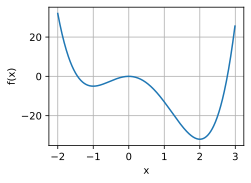

In [2]:
x = torch.arange(-2, 3, 0.01)
f = (3 * x**4) - (4 * x**3) - (12 * x**2)

d2l.plot(x, f, 'x', 'f(x)')

This highlights an important fact to know when working either theoretically or numerically: the only possible points where we can minimize (or maximize) a function will have gradient equal to zero, however, not every point with gradient zero is the true *global* minimum (or maximum).

## Multivariate Chain Rule
Let's suppose that we have a function of four variables ($w, x, y$, and $z$) which we can make by composing many terms:

$$\begin{aligned}f(u, v) & = (u+v)^{2} \\u(a, b) & = (a+b)^{2}, \qquad v(a, b) = (a-b)^{2}, \\a(w, x, y, z) & = (w+x+y+z)^{2}, \qquad b(w, x, y, z) = (w+x-y-z)^2.\end{aligned}$$
:eqlabel:`eq_multi_func_def`

Such chains of equations are common when working with neural networks, so trying to understand how to compute gradients of such functions is key.  We can start to see visual hints of this connection in :numref:`fig_chain-1` if we take a look at what variables directly relate to one another.

![The function relations above where nodes represent values and edges show functional dependence.](../img/chain-net1.svg)
:label:`fig_chain-1`

Nothing stops us from just composing everything from :eqref:`eq_multi_func_def` and writing out that

$$
f(w, x, y, z) = \left(\left((w+x+y+z)^2+(w+x-y-z)^2\right)^2+\left((w+x+y+z)^2-(w+x-y-z)^2\right)^2\right)^2.
$$

We may then take the derivative by just using single variable derivatives, but if we did that we would quickly find ourself swamped with terms, many of which are repeats!  Indeed, one can see that, for instance:

$$
\begin{aligned}
\frac{\partial f}{\partial w} & = 2 \left(2 \left(2 (w + x + y + z) - 2 (w + x - y - z)\right) \left((w + x + y + z)^{2}- (w + x - y - z)^{2}\right) + \right.\\
& \left. \quad 2 \left(2 (w + x - y - z) + 2 (w + x + y + z)\right) \left((w + x - y - z)^{2}+ (w + x + y + z)^{2}\right)\right) \times \\
& \quad \left(\left((w + x + y + z)^{2}- (w + x - y - z)^2\right)^{2}+ \left((w + x - y - z)^{2}+ (w + x + y + z)^{2}\right)^{2}\right).
\end{aligned}
$$

If we then also wanted to compute $\frac{\partial f}{\partial x}$, we would end up with a similar equation again with many repeated terms, and many *shared* repeated terms between the two derivatives.  This represents a massive quantity of wasted work, and if we needed to compute derivatives this way, the whole deep learning revolution would have stalled out before it began!


Let's break up the problem.  We will start by trying to understand how $f$ changes when we change $a$, essentially assuming that $w, x, y$, and $z$ all do not exist.  We will reason as we did back when we worked with the gradient for the first time.  Let's take $a$ and add a small amount $\epsilon$ to it.

$$
\begin{aligned}
& f(u(a+\epsilon, b), v(a+\epsilon, b)) \\
\approx & f\left(u(a, b) + \epsilon\frac{\partial u}{\partial a}(a, b), v(a, b) + \epsilon\frac{\partial v}{\partial a}(a, b)\right) \\
\approx & f(u(a, b), v(a, b)) + \epsilon\left[\frac{\partial f}{\partial u}(u(a, b), v(a, b))\frac{\partial u}{\partial a}(a, b) + \frac{\partial f}{\partial v}(u(a, b), v(a, b))\frac{\partial v}{\partial a}(a, b)\right].
\end{aligned}
$$

The first line follows from the definition of partial derivative, and the second follows from the definition of gradient.  It is notationally burdensome to track exactly where we evaluate every derivative, as in the expression $\frac{\partial f}{\partial u}(u(a, b), v(a, b))$, so we often abbreviate this to the much more memorable

$$
\frac{\partial f}{\partial a} = \frac{\partial f}{\partial u}\frac{\partial u}{\partial a}+\frac{\partial f}{\partial v}\frac{\partial v}{\partial a}.
$$

It is useful to think about the meaning of the process. We are trying to understand how a function of the form $f(u(a, b), v(a, b))$ changes its value with a change in $a$.  There are two pathways this can occur: there is the pathway where $a \rightarrow u \rightarrow f$ and where $a \rightarrow v \rightarrow f$.  We can compute both of these contributions via the chain rule: $\frac{\partial w}{\partial u} \cdot \frac{\partial u}{\partial x}$ and $\frac{\partial w}{\partial v} \cdot \frac{\partial v}{\partial x}$ respectively, and added up.

Imagine we have a different network of functions where the functions on the right depend on those that are connected to on the left as is shown in :numref:`fig_chain-2`.

![Another more subtle example of the chain rule.](../img/chain-net2.svg)
:label:`fig_chain-2`

To compute something like $\frac{\partial f}{\partial y}$, we need to sum over all (in this case $3$) paths from $y$ to $f$ giving

$$
\frac{\partial f}{\partial y} = \frac{\partial f}{\partial a} \frac{\partial a}{\partial u} \frac{\partial u}{\partial y} + \frac{\partial f}{\partial u} \frac{\partial u}{\partial y} + \frac{\partial f}{\partial b} \frac{\partial b}{\partial v} \frac{\partial v}{\partial y}.
$$

Understanding the chain rule in this way will pay great dividends when trying to understand how gradients flow through networks, and why various architectural choices like those in LSTMs (:numref:`sec_lstm`) or residual layers (:numref:`sec_resnet`) can help shape the learning process by controlling gradient flow.

## The Backpropagation Algorithm

Let's return to the example of :eqref:`eq_multi_func_def` the previous section where

$$
\begin{aligned}
f(u, v) & = (u+v)^{2} \\
u(a, b) & = (a+b)^{2}, \qquad v(a, b) = (a-b)^{2}, \\
a(w, x, y, z) & = (w+x+y+z)^{2}, \qquad b(w, x, y, z) = (w+x-y-z)^2.
\end{aligned}
$$

If we want to compute say $\frac{\partial f}{\partial w}$ we may apply the multi-variate chain rule to see:

$$
\begin{aligned}
\frac{\partial f}{\partial w} & = \frac{\partial f}{\partial u}\frac{\partial u}{\partial w} + \frac{\partial f}{\partial v}\frac{\partial v}{\partial w}, \\
\frac{\partial u}{\partial w} & = \frac{\partial u}{\partial a}\frac{\partial a}{\partial w}+\frac{\partial u}{\partial b}\frac{\partial b}{\partial w}, \\
\frac{\partial v}{\partial w} & = \frac{\partial v}{\partial a}\frac{\partial a}{\partial w}+\frac{\partial v}{\partial b}\frac{\partial b}{\partial w}.
\end{aligned}
$$

Let's try using this decomposition to compute $\frac{\partial f}{\partial w}$.  Notice that all we need here are the various single step partials:

$$
\begin{aligned}
\frac{\partial f}{\partial u} = 2(u+v), & \quad\frac{\partial f}{\partial v} = 2(u+v), \\
\frac{\partial u}{\partial a} = 2(a+b), & \quad\frac{\partial u}{\partial b} = 2(a+b), \\
\frac{\partial v}{\partial a} = 2(a-b), & \quad\frac{\partial v}{\partial b} = -2(a-b), \\
\frac{\partial a}{\partial w} = 2(w+x+y+z), & \quad\frac{\partial b}{\partial w} = 2(w+x-y-z).
\end{aligned}
$$

If we write this out into code this becomes a fairly manageable expression.


In [3]:
# Compute the value of the function from inputs to outputs
w, x, y, z = -1, 0, -2, 1
a, b = (w + x + y + z)**2, (w + x - y - z)**2
u, v = (a + b)**2, (a - b)**2
f = (u + v)**2
print(f'    f at {w}, {x}, {y}, {z} is {f}')

# Compute the single step partials
df_du, df_dv = 2*(u + v), 2*(u + v)
du_da, du_db, dv_da, dv_db = 2*(a + b), 2*(a + b), 2*(a - b), -2*(a - b)
da_dw, db_dw = 2*(w + x + y + z), 2*(w + x - y - z)

# Compute the final result from inputs to outputs
du_dw, dv_dw = du_da*da_dw + du_db*db_dw, dv_da*da_dw + dv_db*db_dw
df_dw = df_du*du_dw + df_dv*dv_dw
print(f'df/dw at {w}, {x}, {y}, {z} is {df_dw}')

    f at -1, 0, -2, 1 is 1024
df/dw at -1, 0, -2, 1 is -4096


However, note that this still does not make it easy to compute something like $\frac{\partial f}{\partial x}$.  The reason for that is the *way* we chose to apply the chain rule.  If we look at what we did above, we always kept $\partial w$ in the denominator when we could.  In this way, we chose to apply the chain rule seeing how $w$ changed every other variable.  If that is what we wanted, this would be a good idea.  However, think back to our motivation from deep learning: we want to see how every parameter changes the *loss*.  In essence, we want to apply the chain rule keeping $\partial f$ in the numerator whenever we can!

To be more explicit, note that we can write

$$
\begin{aligned}
\frac{\partial f}{\partial w} & = \frac{\partial f}{\partial a}\frac{\partial a}{\partial w} + \frac{\partial f}{\partial b}\frac{\partial b}{\partial w}, \\
\frac{\partial f}{\partial a} & = \frac{\partial f}{\partial u}\frac{\partial u}{\partial a}+\frac{\partial f}{\partial v}\frac{\partial v}{\partial a}, \\
\frac{\partial f}{\partial b} & = \frac{\partial f}{\partial u}\frac{\partial u}{\partial b}+\frac{\partial f}{\partial v}\frac{\partial v}{\partial b}.
\end{aligned}
$$

Note that this application of the chain rule has us explicitly compute $\frac{\partial f}{\partial u}, \frac{\partial f}{\partial v}, \frac{\partial f}{\partial a}, \frac{\partial f}{\partial b}, \; \textrm{and} \; \frac{\partial f}{\partial w}$.  Nothing stops us from also including the equations:

$$
\begin{aligned}
\frac{\partial f}{\partial x} & = \frac{\partial f}{\partial a}\frac{\partial a}{\partial x} + \frac{\partial f}{\partial b}\frac{\partial b}{\partial x}, \\
\frac{\partial f}{\partial y} & = \frac{\partial f}{\partial a}\frac{\partial a}{\partial y}+\frac{\partial f}{\partial b}\frac{\partial b}{\partial y}, \\
\frac{\partial f}{\partial z} & = \frac{\partial f}{\partial a}\frac{\partial a}{\partial z}+\frac{\partial f}{\partial b}\frac{\partial b}{\partial z}.
\end{aligned}
$$

and then keeping track of how $f$ changes when we change *any* node in the entire network.  Let's implement it.


In [4]:
# Compute the value of the function from inputs to outputs
w, x, y, z = -1, 0, -2, 1
a, b = (w + x + y + z)**2, (w + x - y - z)**2
u, v = (a + b)**2, (a - b)**2
f = (u + v)**2
print(f'f at {w}, {x}, {y}, {z} is {f}')

# Compute the derivative using the decomposition above
# First compute the single step partials
df_du, df_dv = 2*(u + v), 2*(u + v)
du_da, du_db, dv_da, dv_db = 2*(a + b), 2*(a + b), 2*(a - b), -2*(a - b)
da_dw, db_dw = 2*(w + x + y + z), 2*(w + x - y - z)
da_dx, db_dx = 2*(w + x + y + z), 2*(w + x - y - z)
da_dy, db_dy = 2*(w + x + y + z), -2*(w + x - y - z)
da_dz, db_dz = 2*(w + x + y + z), -2*(w + x - y - z)

# Now compute how f changes when we change any value from output to input
df_da, df_db = df_du*du_da + df_dv*dv_da, df_du*du_db + df_dv*dv_db
df_dw, df_dx = df_da*da_dw + df_db*db_dw, df_da*da_dx + df_db*db_dx
df_dy, df_dz = df_da*da_dy + df_db*db_dy, df_da*da_dz + df_db*db_dz

print(f'df/dw at {w}, {x}, {y}, {z} is {df_dw}')
print(f'df/dx at {w}, {x}, {y}, {z} is {df_dx}')
print(f'df/dy at {w}, {x}, {y}, {z} is {df_dy}')
print(f'df/dz at {w}, {x}, {y}, {z} is {df_dz}')

f at -1, 0, -2, 1 is 1024
df/dw at -1, 0, -2, 1 is -4096
df/dx at -1, 0, -2, 1 is -4096
df/dy at -1, 0, -2, 1 is -4096
df/dz at -1, 0, -2, 1 is -4096


The fact that we compute derivatives from $f$ back towards the inputs rather than from the inputs forward to the outputs (as we did in the first code snippet above) is what gives this algorithm its name: *backpropagation*.  Note that there are two steps:
1. Compute the value of the function, and the single step partials from front to back.  While not done above, this can be combined into a single *forward pass*.
2. Compute the gradient of $f$ from back to front.  We call this the *backwards pass*.

This is precisely what every deep learning algorithm implements to allow the computation of the gradient of the loss with respect to every weight in the network at one pass.  It is an astonishing fact that we have such a decomposition.

To see how to encapsulated this, let's take a quick look at this example.


In [5]:
# Initialize as ndarrays, then attach gradients
w = torch.tensor([-1.], requires_grad=True)
x = torch.tensor([0.], requires_grad=True)
y = torch.tensor([-2.], requires_grad=True)
z = torch.tensor([1.], requires_grad=True)
# Do the computation like usual, tracking gradients
a, b = (w + x + y + z)**2, (w + x - y - z)**2
u, v = (a + b)**2, (a - b)**2
f = (u + v)**2

# Execute backward pass
f.backward()

print(f'df/dw at {w.data.item()}, {x.data.item()}, {y.data.item()}, '
      f'{z.data.item()} is {w.grad.data.item()}')
print(f'df/dx at {w.data.item()}, {x.data.item()}, {y.data.item()}, '
      f'{z.data.item()} is {x.grad.data.item()}')
print(f'df/dy at {w.data.item()}, {x.data.item()}, {y.data.item()}, '
      f'{z.data.item()} is {y.grad.data.item()}')
print(f'df/dz at {w.data.item()}, {x.data.item()}, {y.data.item()}, '
      f'{z.data.item()} is {z.grad.data.item()}')

df/dw at -1.0, 0.0, -2.0, 1.0 is -4096.0
df/dx at -1.0, 0.0, -2.0, 1.0 is -4096.0
df/dy at -1.0, 0.0, -2.0, 1.0 is -4096.0
df/dz at -1.0, 0.0, -2.0, 1.0 is -4096.0


All of what we did above can be done automatically by calling `f.backwards()`.


## Hessians
As with single variable calculus, it is useful to consider higher-order derivatives in order to get a handle on how we can obtain a better approximation to a function than using the gradient alone.

There is one immediate problem one encounters when working with higher order derivatives of functions of several variables, and that is there are a large number of them.  If we have a function $f(x_1, \ldots, x_n)$ of $n$ variables, then we can take $n^{2}$ many second derivatives, namely for any choice of $i$ and $j$:

$$
\frac{d^2f}{dx_idx_j} = \frac{d}{dx_i}\left(\frac{d}{dx_j}f\right).
$$

This is traditionally assembled into a matrix called the *Hessian*:

$$\mathbf{H}_f = \begin{bmatrix} \frac{d^2f}{dx_1dx_1} & \cdots & \frac{d^2f}{dx_1dx_n} \\ \vdots & \ddots & \vdots \\ \frac{d^2f}{dx_ndx_1} & \cdots & \frac{d^2f}{dx_ndx_n} \\ \end{bmatrix}.$$
:eqlabel:`eq_hess_def`

Not every entry of this matrix is independent.  Indeed, we can show that as long as both *mixed partials* (partial derivatives with respect to more than one variable) exist and are continuous, we can say that for any $i$, and $j$,

$$
\frac{d^2f}{dx_idx_j} = \frac{d^2f}{dx_jdx_i}.
$$

This follows by considering first perturbing a function in the direction of $x_i$, and then perturbing it in $x_j$ and then comparing the result of that with what happens if we perturb first $x_j$ and then $x_i$, with the knowledge that both of these orders lead to the same final change in the output of $f$.

As with single variables, we can use these derivatives to get a far better idea of how the function behaves near a point.  In particular, we can use it to find the best fitting quadratic near a point $\mathbf{x}_0$, as we saw in a single variable.

Let's see an example.  Suppose that $f(x_1, x_2) = a + b_1x_1 + b_2x_2 + c_{11}x_1^{2} + c_{12}x_1x_2 + c_{22}x_2^{2}$.  This is the general form for a quadratic in two variables.  If we look at the value of the function, its gradient, and its Hessian :eqref:`eq_hess_def`, all at the point zero:

$$
\begin{aligned}
f(0,0) & = a, \\
\nabla f (0,0) & = \begin{bmatrix}b_1 \\ b_2\end{bmatrix}, \\
\mathbf{H} f (0,0) & = \begin{bmatrix}2 c_{11} & c_{12} \\ c_{12} & 2c_{22}\end{bmatrix},
\end{aligned}
$$

we can get our original polynomial back by saying

$$
f(\mathbf{x}) = f(0) + \nabla f (0) \cdot \mathbf{x} + \frac{1}{2}\mathbf{x}^\top \mathbf{H} f (0) \mathbf{x}.
$$

In general, if we computed this expansion any point $\mathbf{x}_0$, we see that

$$
f(\mathbf{x}) = f(\mathbf{x}_0) + \nabla f (\mathbf{x}_0) \cdot (\mathbf{x}-\mathbf{x}_0) + \frac{1}{2}(\mathbf{x}-\mathbf{x}_0)^\top \mathbf{H} f (\mathbf{x}_0) (\mathbf{x}-\mathbf{x}_0).
$$

This works for any dimensional input, and provides the best approximating quadratic to any function at a point.  To give an example, let's plot the function

$$
f(x, y) = xe^{-x^2-y^2}.
$$

One can compute that the gradient and Hessian are
$$
\nabla f(x, y) = e^{-x^2-y^2}\begin{pmatrix}1-2x^2 \\ -2xy\end{pmatrix} \; \textrm{and} \; \mathbf{H}f(x, y) = e^{-x^2-y^2}\begin{pmatrix} 4x^3 - 6x & 4x^2y - 2y \\ 4x^2y-2y &4xy^2-2x\end{pmatrix}.
$$

And thus, with a little algebra, see that the approximating quadratic at $[-1,0]^\top$ is

$$
f(x, y) \approx e^{-1}\left(-1 - (x+1) +(x+1)^2+y^2\right).
$$


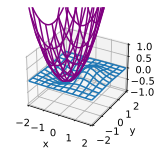

In [6]:
# Construct grid and compute function
x, y = torch.meshgrid(torch.linspace(-2, 2, 101),
                   torch.linspace(-2, 2, 101))

z = x*torch.exp(- x**2 - y**2)

# Compute approximating quadratic with gradient and Hessian at (1, 0)
w = torch.exp(torch.tensor([-1.]))*(-1 - (x + 1) + 2 * (x + 1)**2 + 2 * y**2)

# Plot function
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x.numpy(), y.numpy(), z.numpy(),
                  **{'rstride': 10, 'cstride': 10})
ax.plot_wireframe(x.numpy(), y.numpy(), w.numpy(),
                  **{'rstride': 10, 'cstride': 10}, color='purple')
d2l.plt.xlabel('x')
d2l.plt.ylabel('y')
d2l.set_figsize()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-1, 1)
ax.dist = 12

This forms the basis for Newton's Algorithm discussed in :numref:`sec_gd`, where we perform numerical optimization iteratively finding the best fitting quadratic, and then exactly minimizing that quadratic.

## A Little Matrix Calculus
Derivatives of functions involving matrices turn out to be particularly nice.  This section can become notationally heavy, so may be skipped in a first reading, but it is useful to know how derivatives of functions involving common matrix operations are often much cleaner than one might initially anticipate, particularly given how central matrix operations are to deep learning applications.

Let's begin with an example.  Suppose that we have some fixed column vector $\boldsymbol{\beta}$, and we want to take the product function $f(\mathbf{x}) = \boldsymbol{\beta}^\top\mathbf{x}$, and understand how the dot product changes when we change $\mathbf{x}$.

A bit of notation that will be useful when working with matrix derivatives in ML is called the *denominator layout matrix derivative* where we assemble our partial derivatives into the shape of whatever vector, matrix, or tensor is in the denominator of the differential.  In this case, we will write

$$
\frac{df}{d\mathbf{x}} = \begin{bmatrix}
\frac{df}{dx_1} \\
\vdots \\
\frac{df}{dx_n}
\end{bmatrix},
$$

where we matched the shape of the column vector $\mathbf{x}$.

If we write out our function into components this is

$$
f(\mathbf{x}) = \sum_{i = 1}^{n} \beta_ix_i = \beta_1x_1 + \cdots + \beta_nx_n.
$$

If we now take the partial derivative with respect to say $\beta_1$, note that everything is zero but the first term, which is just $x_1$ multiplied by $\beta_1$, so we obtain that

$$
\frac{df}{dx_1} = \beta_1,
$$

or more generally that

$$
\frac{df}{dx_i} = \beta_i.
$$

We can now reassemble this into a matrix to see

$$
\frac{df}{d\mathbf{x}} = \begin{bmatrix}
\frac{df}{dx_1} \\
\vdots \\
\frac{df}{dx_n}
\end{bmatrix} = \begin{bmatrix}
\beta_1 \\
\vdots \\
\beta_n
\end{bmatrix} = \boldsymbol{\beta}.
$$

This illustrates a few factors about matrix calculus that we will often counter throughout this section:

* First, The computations will get rather involved.
* Second, The final results are much cleaner than the intermediate process, and will always look similar to the single variable case.  In this case, note that $\frac{d}{dx}(bx) = b$ and $\frac{d}{d\mathbf{x}} (\boldsymbol{\beta}^\top\mathbf{x}) = \boldsymbol{\beta}$ are both similar.
* Third, transposes can often appear seemingly from nowhere.  The core reason for this is the convention that we match the shape of the denominator, thus when we multiply matrices, we will need to take transposes to match back to the shape of the original term.

To keep building intuition, let's try a computation that is a little harder.  Suppose that we have a column vector $\mathbf{x}$, and a square matrix $A$ and we want to compute

$$\frac{d}{d\mathbf{x}}(\mathbf{x}^\top A \mathbf{x}).$$
:eqlabel:`eq_mat_goal_1`

To drive towards easier to manipulate notation, let's consider this problem using Einstein notation.  In this case we can write the function as

$$
\mathbf{x}^\top A \mathbf{x} = x_ia_{ij}x_j.
$$

To compute our derivative, we need to understand for every $k$, what is the value of

$$
\frac{d}{dx_k}(\mathbf{x}^\top A \mathbf{x}) = \frac{d}{dx_k}x_ia_{ij}x_j.
$$

By the product rule, this is

$$
\frac{d}{dx_k}x_ia_{ij}x_j = \frac{dx_i}{dx_k}a_{ij}x_j + x_ia_{ij}\frac{dx_j}{dx_k}.
$$

For a term like $\frac{dx_i}{dx_k}$, it is not hard to see that this is one when $i=k$ and zero otherwise.  This means that every term where $i$ and $k$ are different vanish from this sum, so the only terms that remain in that first sum are the ones where $i=k$.  The same reasoning holds for the second term where we need $j=k$.  This gives

$$
\frac{d}{dx_k}x_ia_{ij}x_j = a_{kj}x_j + x_ia_{ik}.
$$

Now, the names of the indices in Einstein notation are arbitrary---the fact that $i$ and $j$ are different is immaterial to this computation at this point, so we can re-index so that they both use $i$ to see that

$$
\frac{d}{dx_k}x_ia_{ij}x_j = a_{ki}x_i + x_ia_{ik} = (a_{ki} + a_{ik})x_i.
$$

Now, here is where we start to need some practice to go further.  Let's try and identify this outcome in terms of matrix operations.  $a_{ki} + a_{ik}$ is the $k, i$-th component of $\mathbf{A} + \mathbf{A}^\top$.  This gives

$$
\frac{d}{dx_k}x_ia_{ij}x_j = [\mathbf{A} + \mathbf{A}^\top]_{ki}x_i.
$$

Similarly, this term is now the product of the matrix $\mathbf{A} + \mathbf{A}^\top$ by the vector $\mathbf{x}$, so we see that

$$
\left[\frac{d}{d\mathbf{x}}(\mathbf{x}^\top A \mathbf{x})\right]_k = \frac{d}{dx_k}x_ia_{ij}x_j = [(\mathbf{A} + \mathbf{A}^\top)\mathbf{x}]_k.
$$

Thus, we see that the $k$-th entry of the desired derivative from :eqref:`eq_mat_goal_1` is just the $k$-th entry of the vector on the right, and thus the two are the same.  Thus yields

$$
\frac{d}{d\mathbf{x}}(\mathbf{x}^\top A \mathbf{x}) = (\mathbf{A} + \mathbf{A}^\top)\mathbf{x}.
$$

This required significantly more work than our last one, but the final result is small.  More than that, consider the following computation for traditional single variable derivatives:

$$
\frac{d}{dx}(xax) = \frac{dx}{dx}ax + xa\frac{dx}{dx} = (a+a)x.
$$

Equivalently $\frac{d}{dx}(ax^2) = 2ax = (a+a)x$.  Again, we get a result that looks rather like the single variable result but with a transpose tossed in.

At this point, the pattern should be looking rather suspicious, so let's try to figure out why.  When we take matrix derivatives like this, let's first assume that the expression we get will be another matrix expression: an expression we can write it in terms of products and sums of matrices and their transposes.  If such an expression exists, it will need to be true for all matrices.  In particular, it will need to be true of $1 \times 1$ matrices, in which case the matrix product is just the product of the numbers, the matrix sum is just the sum, and the transpose does nothing at all!  In other words, whatever expression we get *must* match the single variable expression.  This means that, with some practice, one can often guess matrix derivatives just by knowing what the associated single variable expression must look like!

Let's try this out.  Suppose that $\mathbf{X}$ is a $n \times m$ matrix, $\mathbf{U}$ is an $n \times r$ and $\mathbf{V}$ is an $r \times m$.  Let's try to compute

$$\frac{d}{d\mathbf{V}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2} = \;?$$
:eqlabel:`eq_mat_goal_2`

This computation is important in an area called matrix factorization.  For us, however, it is just a derivative to compute.  Let's try to imagine what this would be for $1\times1$ matrices.  In that case, we get the expression

$$
\frac{d}{dv} (x-uv)^{2}= -2(x-uv)u,
$$

where, the derivative is rather standard.  If we try to convert this back into a matrix expression we get

$$
\frac{d}{d\mathbf{V}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= -2(\mathbf{X} - \mathbf{U}\mathbf{V})\mathbf{U}.
$$

However, if we look at this it does not quite work.  Recall that $\mathbf{X}$ is $n \times m$, as is $\mathbf{U}\mathbf{V}$, so the matrix $2(\mathbf{X} - \mathbf{U}\mathbf{V})$ is $n \times m$.  On the other hand $\mathbf{U}$ is $n \times r$, and we cannot multiply a $n \times m$ and a $n \times r$ matrix since the dimensions do not match!

We want to get $\frac{d}{d\mathbf{V}}$, which is the same shape as $\mathbf{V}$, which is $r \times m$.  So somehow we need to take a $n \times m$ matrix and a $n \times r$ matrix, multiply them together (perhaps with some transposes) to get a $r \times m$. We can do this by multiplying $U^\top$ by $(\mathbf{X} - \mathbf{U}\mathbf{V})$.  Thus, we can guess the solution to :eqref:`eq_mat_goal_2` is

$$
\frac{d}{d\mathbf{V}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= -2\mathbf{U}^\top(\mathbf{X} - \mathbf{U}\mathbf{V}).
$$

To show that this works, we would be remiss to not provide a detailed computation.  If we already believe that this rule-of-thumb works, feel free to skip past this derivation.  To compute

$$
\frac{d}{d\mathbf{V}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^2,
$$

we must find for every $a$, and $b$

$$
\frac{d}{dv_{ab}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= \frac{d}{dv_{ab}} \sum_{i, j}\left(x_{ij} - \sum_k u_{ik}v_{kj}\right)^2.
$$

Recalling that all entries of $\mathbf{X}$ and $\mathbf{U}$ are constants as far as $\frac{d}{dv_{ab}}$ is concerned, we may push the derivative inside the sum, and apply the chain rule to the square to get

$$
\frac{d}{dv_{ab}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= \sum_{i, j}2\left(x_{ij} - \sum_k u_{ik}v_{kj}\right)\left(-\sum_k u_{ik}\frac{dv_{kj}}{dv_{ab}} \right).
$$

As in the previous derivation, we may note that $\frac{dv_{kj}}{dv_{ab}}$ is only non-zero if the $k=a$ and $j=b$.  If either of those conditions do not hold, the term in the sum is zero, and we may freely discard it.  We see that

$$
\frac{d}{dv_{ab}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= -2\sum_{i}\left(x_{ib} - \sum_k u_{ik}v_{kb}\right)u_{ia}.
$$

An important subtlety here is that the requirement that $k=a$ does not occur inside the inner sum since that $k$ is a dummy variable which we are summing over inside the inner term.  For a notationally cleaner example, consider why

$$
\frac{d}{dx_1} \left(\sum_i x_i \right)^{2}= 2\left(\sum_i x_i \right).
$$

From this point, we may start identifying components of the sum.  First,

$$
\sum_k u_{ik}v_{kb} = [\mathbf{U}\mathbf{V}]_{ib}.
$$

So the entire expression in the inside of the sum is

$$
x_{ib} - \sum_k u_{ik}v_{kb} = [\mathbf{X}-\mathbf{U}\mathbf{V}]_{ib}.
$$

This means we may now write our derivative as

$$
\frac{d}{dv_{ab}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= -2\sum_{i}[\mathbf{X}-\mathbf{U}\mathbf{V}]_{ib}u_{ia}.
$$

We want this to look like the $a, b$ element of a matrix so we can use the technique as in the previous example to arrive at a matrix expression, which means that we need to exchange the order of the indices on $u_{ia}$.  If we notice that $u_{ia} = [\mathbf{U}^\top]_{ai}$, we can then write

$$
\frac{d}{dv_{ab}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= -2\sum_{i} [\mathbf{U}^\top]_{ai}[\mathbf{X}-\mathbf{U}\mathbf{V}]_{ib}.
$$

This is a matrix product, and thus we can conclude that

$$
\frac{d}{dv_{ab}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= -2[\mathbf{U}^\top(\mathbf{X}-\mathbf{U}\mathbf{V})]_{ab}.
$$

and thus we may write the solution to :eqref:`eq_mat_goal_2`

$$
\frac{d}{d\mathbf{V}} \|\mathbf{X} - \mathbf{U}\mathbf{V}\|_2^{2}= -2\mathbf{U}^\top(\mathbf{X} - \mathbf{U}\mathbf{V}).
$$

This matches the solution we guessed above!

It is reasonable to ask at this point, "Why can I not just write down matrix versions of all the calculus rules I have learned?  It is clear this is still mechanical.  Why do we not just get it over with!"  And indeed there are such rules and :cite:`Petersen.Pedersen.ea.2008` provides an excellent summary.  However, due to the plethora of ways matrix operations can be combined compared to single values, there are many more matrix derivative rules than single variable ones.  It is often the case that it is best to work with the indices, or leave it up to automatic differentiation when appropriate.

## Summary

* In higher dimensions, we can define gradients which serve the same purpose as derivatives in one dimension.  These allow us to see how a multi-variable function changes when we make an arbitrary small change to the inputs.
* The backpropagation algorithm can be seen to be a method of organizing the multi-variable chain rule to allow for the efficient computation of many partial derivatives.
* Matrix calculus allows us to write the derivatives of matrix expressions in concise ways.

## Exercises
1. Given a column vector $\boldsymbol{\beta}$, compute the derivatives of both $f(\mathbf{x}) = \boldsymbol{\beta}^\top\mathbf{x}$ and $g(\mathbf{x}) = \mathbf{x}^\top\boldsymbol{\beta}$.  Why do you get the same answer?
2. Let $\mathbf{v}$ be an $n$ dimension vector. What is $\frac{\partial}{\partial\mathbf{v}}\|\mathbf{v}\|_2$?
3. Let $L(x, y) = \log(e^x + e^y)$.  Compute the gradient.  What is the sum of the components of the gradient?
4. Let $f(x, y) = x^2y + xy^2$. Show that the only critical point is $(0,0)$. By considering $f(x, x)$, determine if $(0,0)$ is a maximum, minimum, or neither.
5. Suppose that we are minimizing a function $f(\mathbf{x}) = g(\mathbf{x}) + h(\mathbf{x})$.  How can we geometrically interpret the condition of $\nabla f = 0$ in terms of $g$ and $h$?


[Discussions](https://discuss.d2l.ai/t/1090)
